### Import Livneh reanalysis data

In [2]:
import numpy as np
import scipy as sp
import netCDF4 as nc4

In [2]:
datapath_input = '/data1/adalbert/livneh/Livneh.AtmVar.CA.4km.2003_2013.nc'
datapath_output= '/data1/adalbert/livneh/Livneh.LndVar.CA.4km.2003_2013.nc'

In [6]:
f_in = nc4.Dataset(datapath_input,'r')
f_out= nc4.Dataset(datapath_output,'r')

In [13]:
f_in.variables.keys()

[u'lon', u'lat', u'time', u'Prec', u'Tmax', u'Tmin', u'wind']

In [9]:
f_out.variables.keys()

[u'lon',
 u'lat',
 u'lev',
 u'time',
 u'Baseflow',
 u'GroundHeat',
 u'LatentHeat',
 u'NetRad',
 u'PETLong',
 u'PETNatVeg',
 u'PETShort',
 u'Runoff',
 u'SWE',
 u'SensibleHeat',
 u'SoilMoist',
 u'TotalET',
 u'WDEW']

In [19]:
# Extract data from NetCDF file
def extract_data(nc_fid, fields):
    lats = nc_fid.variables['lat'][:]  # extract/copy the data
    lons = nc_fid.variables['lon'][:]
    time = nc_fid.variables['time'][:]
    field = []
    for f in fields:
        field.append(nc_fid.variables[f][:])
    field = np.stack(field)
    return lats, lons, time, field

In [29]:
variables = [u'Prec', u'Tmax', u'Tmin', u'wind']
lats_in, lons_in, time_in, input_data = extract_data(f_in, variables)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


In [30]:
input_data = input_data.transpose((1,2,3,0))

In [17]:
lats_out, lons_out, time_out, swe = extract_data(f_out, ['SWE'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [31]:
input_data.shape, swe.shape

((4018, 321, 321, 4), (4018, 321, 321))

In [44]:
metadata_in = zip(lats_in, lons_in, time_in)
metadata_out= zip(lats_out, lons_out, time_out)

### Split into train/test, save data to numpy format

In [34]:
output_dir = "./livneh/"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [45]:
frac_train = 0.8
idx_train = int(len(input_data) * frac_train)
trainA = input_data[:idx_train]
testA = input_data[idx_train:]
trainA_meta = metadata_in[:idx_train]
testA_meta = metadata_in[idx_train:]

trainB = swe[:idx_train]
testB = swe[idx_train:]
trainB_meta = metadata_out[:idx_train]
testB_meta = metadata_out[idx_train:]


In [49]:
# save train/test files

np.savez_compressed(output_dir + "trainA.npz", data=trainA, variables=variables, metadata=trainA_meta)
np.savez_compressed(output_dir + "trainB.npz", data=trainB, variables=['SWE'], metadata=trainB_meta)
np.savez_compressed(output_dir + "testA.npz", data=testA, variables=variables, metadata=testA_meta)
np.savez_compressed(output_dir + "testB.npz", data=testB, variables=['SWE'], metadata=testB_meta)

In [50]:
# save each sample in its own file
# this mimicks the way GAN frameworks work currently 

for data, meta, split, fields in zip([trainA, trainB, testA, testB], 
                             [trainA_meta, trainB_meta, testA_meta, testB_meta], 
                             ["trainA", "trainB", "testA", "testB"],
                             [variables, ['SWE'], variables, ['SWE']]):
    print "Dumping %s split..." % split 
    cur_dir = output_dir + split + "/"
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
    for i,(sample,info) in enumerate(zip(data,meta)):
        np.savez_compressed(cur_dir + "%s.npz"%i, data=sample, variables=fields, metadata=info)
 
    

Dumping trainA split...
Dumping trainB split...
Dumping testA split...
Dumping testB split...


## Inspect saved samples

In [8]:
x = np.load(output_dir + "trainA/100.npz")

In [12]:
x['data'].shape

(321, 321, 4)

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

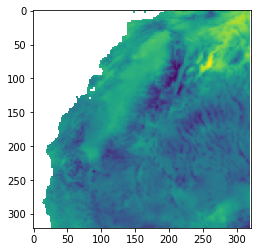

In [34]:
plt.imshow(x['data'][...,2])

Text(0.5,0,'Data value')

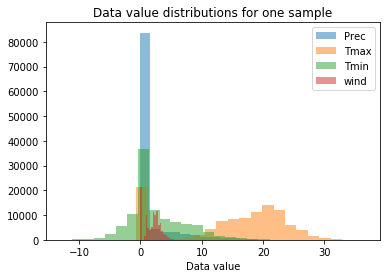

In [32]:
for i,v in enumerate(variables):
    plt.hist(np.nan_to_num(x['data'][...,i].flatten()), alpha=0.5, label=v, bins=20)
plt.legend(loc="best")
plt.title("Data value distributions for one sample")
plt.xlabel("Data value")

In [35]:
from skimage.transform import resize


In [37]:
resize(x['data'], (256,256)).shape

(256, 256, 4)